In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

2024-02-25 19:11:26.858599: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-25 19:11:26.861340: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-25 19:11:26.898224: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-25 19:11:26.898261: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-25 19:11:26.899224: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
def readFile(path):
    try:
        with open(path, 'r') as file:
            # Skip the first line
            first_line_skipped = False

            # Array to store characters
            temp = []

            # Read and append characters to the array
            for line in file:
                if not first_line_skipped:
                    first_line_skipped = True
                    continue  # Skip the first line
                temp.extend(line.strip())

            # Print the length of sequences
            print(len(temp))
    except FileNotFoundError:
        print(f"File not found: {path}")
    except Exception as e:
        print(f"An error occurred: {e}")
    return temp

In [3]:
def pad_genome_sequences(sequence, max_length, padding_char='A'):
    if len(sequence) < max_length:
        # Add padding to the end
        padded_sequence = sequence + list(padding_char * (max_length - len(sequence)))
    elif len(sequence) > max_length:
        # Optionally truncate longer sequences
        padded_sequence = sequence[:max_length]
    else:
        padded_sequence = sequence
        
    print(len(padded_sequence))
    return padded_sequence


In [4]:
# One-hot encoding
def one_hot_encode(sequence):
    encoding = {'A': [1, 0, 0, 0], 'T': [0, 1, 0, 0], 'C': [0, 0, 1, 0], 'G': [0, 0, 0, 1]}
    return np.array([encoding[base] for base in sequence])

In [5]:
def encode(seq1,seq2,seq3,seq4):
    var1 = np.array(one_hot_encode(seq1))
    var2 = np.array(one_hot_encode(seq2))
    temp = np.concatenate((var1[np.newaxis, :], var2[np.newaxis, :]), axis=0)
    var3 = np.array(one_hot_encode(seq3))
    temp = np.concatenate((temp, var3[np.newaxis, :]), axis=0)
    var4 = np.array(one_hot_encode(seq4))
    temp = np.concatenate((temp, var4[np.newaxis, :]), axis=0)
    print(np.shape(temp))
    return temp

In [6]:
HCov229E = readFile('./HCov-229E/ncbi_dataset/data/GCA_000853505.1/GCA_000853505.1_ViralProj14913_genomic.fna')
HCovHKU1 = readFile('./HCov-HKU1/ncbi_dataset/data/GCA_000858765.1/GCA_000858765.1_ViralProj15139_genomic.fna')
HCovNL63 = readFile('./HCov-NL63/ncbi_dataset/data/GCA_000853865.1/GCA_000853865.1_ViralProj14960_genomic.fna')
MERSCoV = readFile('./MERS-CoV/ncbi_dataset/data/GCA_000901155.1/GCA_000901155.1_ViralProj183710_genomic.fna')
SARSCoV = readFile('./SARS-CoV/ncbi_dataset/data/GCA_000864885.1/GCA_000864885.1_ViralProj15500_genomic.fna')
SARSCoV2 = readFile('./SARS-CoV-2/ncbi_dataset/data/genomic.fna')

27317
29926
27553
30119
29751
29903


In [7]:
max_length = max(len(seq) for seq in [SARSCoV, SARSCoV2, MERSCoV, HCov229E, HCovHKU1, HCovNL63])
SARSCoV = pad_genome_sequences(SARSCoV, max_length)
SARSCoV2 = pad_genome_sequences(SARSCoV2, max_length)
MERSCoV = pad_genome_sequences(MERSCoV, max_length)
HCov229E = pad_genome_sequences(HCov229E, max_length)
HCovHKU1 = pad_genome_sequences(HCovHKU1, max_length)
HCovNL63 = pad_genome_sequences(HCovNL63, max_length)

30119
30119
30119
30119
30119
30119


In [8]:
# Convert sequences to categorical for training
X_original = encode(HCov229E,HCovNL63,SARSCoV,HCovHKU1)
y_original = encode(HCovNL63,SARSCoV,HCovHKU1,MERSCoV)

(4, 30119, 4)
(4, 30119, 4)


In [9]:
# Train-test split
split_index = int(len(X_original) * 0.75)
X_train_original, X_test_original = X_original[:split_index], X_original[split_index:]
y_train_original, y_test_original = y_original[:split_index], y_original[split_index:]

In [10]:
# Build the Many-to-Many LSTM model
model = Sequential()
model.add(LSTM(500, input_shape=(X_train_original.shape[1], X_train_original.shape[2]), return_sequences=True))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [11]:
# Train the model
history = model.fit(X_train_original, y_train_original, epochs=10, batch_size=5, validation_data=(X_test_original, y_test_original))

Epoch 1/10
1/1 [==============================] - 44s 44s/step - loss: 1.3912 - accuracy: 0.1571 - val_loss: 1.3727 - val_accuracy: 0.3243
Epoch 2/10
1/1 [==============================] - 42s 42s/step - loss: 1.3553 - accuracy: 0.3865 - val_loss: 1.3690 - val_accuracy: 0.3253
Epoch 3/10
1/1 [==============================] - 41s 41s/step - loss: 1.3296 - accuracy: 0.3878 - val_loss: 1.4206 - val_accuracy: 0.3255
Epoch 4/10
1/1 [==============================] - 43s 43s/step - loss: 1.3356 - accuracy: 0.3894 - val_loss: 1.3812 - val_accuracy: 0.3198
Epoch 5/10
1/1 [==============================] - 46s 46s/step - loss: 1.3174 - accuracy: 0.3766 - val_loss: 1.3744 - val_accuracy: 0.3166
Epoch 6/10
1/1 [==============================] - 44s 44s/step - loss: 1.3166 - accuracy: 0.3731 - val_loss: 1.3762 - val_accuracy: 0.3220
Epoch 7/10
1/1 [==============================] - 46s 46s/step - loss: 1.3237 - accuracy: 0.3799 - val_loss: 1.3733 - val_accuracy: 0.3238
Epoch 8/10
1/1 [===========

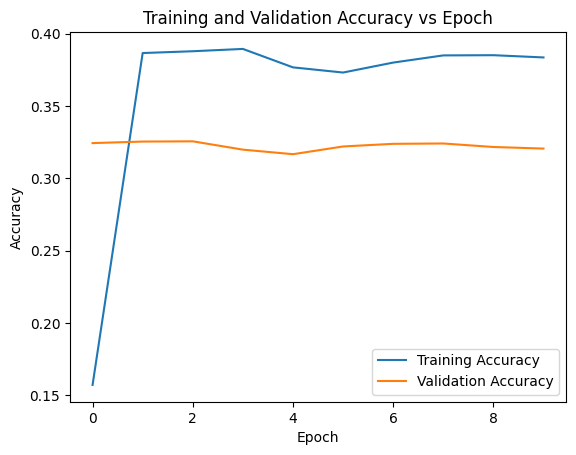

In [12]:
import matplotlib.pyplot as plt

# Plot the accuracy vs epoch graph
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
import tensorflow as tf

# Load the model
loaded_model = tf.keras.models.load_model("MODEL1.h5")

In [14]:
accuracy = model.evaluate(X_test_original, y_test_original)
print(f"Test Accuracy: {accuracy[1] * 100:.2f}%")

1/1 [==============================] - 3s 3s/step - loss: 1.3714 - accuracy: 0.3205
Test Accuracy: 32.05%


In [15]:
## Given input sequence for prediction
input_sequence = MERSCoV

# One-hot encode the input sequence
X_input = np.array(one_hot_encode(HCovNL63))
X_input = X_input[np.newaxis, :]
print(np.shape(X_input))


# Predict mutated sequence
predicted_sequence_encoded = model.predict(X_input)

# Decode the predicted sequence from one-hot encoding
base_encoding = {0: 'A', 1: 'T', 2: 'C', 3: 'G'}
predicted_sequence = ''.join([base_encoding[np.argmax(base)] for base in predicted_sequence_encoded[0]])

print(f"Original Sequence: {''.join([str(i) for i in input_sequence])}")
print(f"Predicted Mutated Sequence: {predicted_sequence}")

(1, 30119, 4)
1/1 [==============================] - 4s 4s/step
Original Sequence: GATTTAAGTGAATAGCTTGGCTATCTCACTTCCCCTCGTTCTCTTGCAGAACTTTGATTTTAACGAACTTAAATAAAAGCCCTGTTGTTTAGCGTATCGTTGCACTTGTCTGGTGGGATTGTGGCATTAATTTGCCTGCTCATCTAGGCAGTGGACATATGCTCAACACTGGGTATAATTCTAATTGAATACTATTTTTCAGTTAGAGCGTCGTGTCTCTTGTACGTCTCGGTCACAATACACGGTTTCGTCCGGTGCGTGGCAATTCGGGGCACATCATGTCTTTCGTGGCTGGTGTGACCGCGCAAGGTGCGCGCGGTACGTATCGAGCAGCGCTCAACTCTGAAAAACATCAAGACCATGTGTCTCTAACTGTGCCACTCTGTGGTTCAGGAAACCTGGTTGAAAAACTTTCACCATGGTTCATGGATGGCGAAAATGCCTATGAAGTGGTGAAGGCCATGTTACTTAAAAAGGAGCCACTTCTCTATGTGCCCATCCGGCTGGCTGGACACACTAGACACCTCCCAGGTCCTCGTGTGTACCTGGTTGAGAGGCTCATTGCTTGTGAAAATCCATTCATGGTTAACCAATTGGCTTATAGCTCTAGTGCAAATGGCAGCCTGGTTGGCACAACTTTGCAGGGCAAGCCTATTGGTATGTTCTTCCCTTATGACATCGAACTTGTCACAGGAAAGCAAAATATTCTCCTGCGCAAGTATGGCCGTGGTGGTTATCACTACACCCCATTCCACTATGAGCGAGACAACACCTCTTGCCCTGAGTGGATGGACGATTTTGAGGCGGATCCTAAAGGCAAATATGCCCAGAATCTGCTTAAGAAGTTGATTGGCGGTGATGTCACTCCAGTTGACCAATACATGTGTGGCGTTGATGGAAAACCCATTAGTGCCTAC

In [16]:
model.save("MODEL1.h5")

/home/pranesh/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
